# Other checking

In [1]:
# import pickle
# with open(f"../input/config7epoch10/out_val.p", 'rb') as f: #OK

#     out_val = pickle.load(f)

In [2]:
# out_valA

In [3]:
# valid = pd.read_csv('../input/glrv2test/recognition_solution_v2.1.csv')A

In [4]:
# # valid = pd.read_csv('../input/glrv2test/recognition_solution_v2.1.csv')

# valid = pd.read_csv('../../input/GLDv2/recognition_solution_v2.1.csv')
# valid=valid[valid.landmarks.isna()]
# valid["img_folder"] = '../../input/GLDv2/' + 'test/'
# valid['target'] = 0
# valid=valid[['id','img_folder','target']]
# valid.reset_index(drop=True,inplace=True)

# valid

# Config1 test embeddings

In [5]:
import sys
import importlib
from types import SimpleNamespace
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.special import softmax
from joblib import Parallel, delayed
import seaborn as sns
import scipy as sp

import warnings
import pandas as pd

import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

warnings.filterwarnings("ignore")

# sys.path.append("../input/githubdata/src")
# sys.path.append("../input/githubdata/configs")

sys.path.append("../input/githubdata0921/src")
sys.path.append("../input/githubdata0921/configs")

sys.argv = ['--config', 'config1']

In [6]:
import sys
import importlib
from types import SimpleNamespace
import argparse

sys.path.append("../configs")

parser = argparse.ArgumentParser(description='')

parser.add_argument("-C", "--config", help="config filename")
parser_args, _ = parser.parse_known_args(sys.argv)

print("Using config file", parser_args.config)

args = importlib.import_module(parser_args.config).args

args["experiment_name"] = parser_args.config

args =  SimpleNamespace(**args)

args.img_path_train = args.data_path + 'train/'
args.img_path_val = args.data_path_2019 + 'test/'
args.img_path_test = args.data_path + 'test/'

Using config file config1


In [7]:

# sys.argv = ['--config', 'config7']

from models import *
from loss import *
from train import *
from data import *
import pickle
import numpy as np

Using config file config1


In [8]:
sys.argv

['--config', 'config1']

In [9]:
args

namespace(model_path='../models/',
          data_path='../../input/',
          data_path_2019='../../input/GLDv2/',
          valid_csv_fn='recognition_solution_v2.1.csv',
          train_csv_fn='train.csv',
          gpus='0,1,2,3',
          filter_warnings=True,
          logger='neptune',
          num_sanity_val_steps=0,
          distributed_backend='ddp',
          channels_last=False,
          gradient_accumulation_steps=2,
          precision=16,
          sync_batchnorm=False,
          seed=1138,
          num_workers=8,
          save_weights_only=True,
          p_trainable=True,
          resume_from_checkpoint=None,
          pretrained_weights=None,
          normalization='imagenet',
          crop_size=448,
          backbone='gluon_seresnext101_32x4d',
          embedding_size=512,
          pool='gem',
          arcface_s=45,
          arcface_m=0.4,
          neck='option-D',
          head='arc_margin',
          crit='bce',
          loss='arcface',
          

In [10]:
import sys
import importlib
from types import SimpleNamespace
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.special import softmax
from joblib import Parallel, delayed
import seaborn as sns

# sys.path.append("../src")
# sys.path.append("../configs")

# sys.argv = ['--config', 'config1']

from models import *
from loss import *
from train import *
from data import *

def gpu_unravel(batch):
        input_dict, target_dict = batch
        input_dict = {k: input_dict[k].cuda() for k in input_dict}
        target_dict = {k: target_dict[k].cuda() for k in target_dict}
        return input_dict, target_dict
    
dict_unravel = gpu_unravel

In [11]:
name = "config1"
# pretrained_weights = "../input/config1epoch10/config1_ckpt_10.pth"
pretrained_weights = "../input/config1epoch10check/config1_ckpt_10.pth"

# name = "config7"
# pretrained_weights = "../input/config7epoch10/config7_ckpt_10.pth"


# csv = "train"
csv = "test"

#このtrainはGLRv2のfull trainだと思う。
test = pd.read_csv(f"../input/landmark-recognition-2021/sample_submission.csv")

test["img_folder"] = "../input/landmark-recognition-2021/test/"
test["target"] = 0

In [12]:
test

,id,landmarks,img_folder,target
0,00084cdf8f600d00,137790 0.1,../input/landmark-recognition-2021/test/,0
1,000b15b043eb8cf0,137790 0.1,../input/landmark-recognition-2021/test/,0
2,0011a52f9b948fd2,137790 0.1,../input/landmark-recognition-2021/test/,0
3,00141b8a5a729084,137790 0.1,../input/landmark-recognition-2021/test/,0
4,0018aa4b92532b77,137790 0.1,../input/landmark-recognition-2021/test/,0
...,...,...,...,...
10340,ffc41ddbcf63289b,137790 0.1,../input/landmark-recognition-2021/test/,0
10341,ffd4c19b7732cbe9,137790 0.1,../input/landmark-recognition-2021/test/,0
10342,ffee2cac79a173d6,137790 0.1,../input/landmark-recognition-2021/test/,0
10343,ffef459d5dc6b981,137790 0.1,../input/landmark-recognition-2021/test/,0


In [13]:
#config1
aug = A.Compose([ 
                A.SmallestMaxSize(512),
                A.CenterCrop(always_apply=False, p=1.0, height=512, width=512), 
                ], 
                p=1.0
                )

# #config7
# aug = A.Compose([
#                 A.Resize(height=544,width=672,p=1.),
#                 A.CenterCrop(always_apply=False, height=544,width=672,p=1.),
#                 ],
#                 p=1.0)

In [14]:
#----検証の時
# test=test[:100]

In [15]:
val_ds = GLRDataset(test, normalization=args.normalization, aug=aug)

batch_size = 8
val_dl = DataLoader(dataset=val_ds,
                    batch_size=batch_size,
                    sampler=SequentialSampler(val_ds), collate_fn=collate_fn, num_workers=2, pin_memory=True)

In [16]:
print(args.backbone)

gluon_seresnext101_32x4d


In [17]:
model = Net(args,pretrained=False)
model.eval()
model.cuda()
model.load_state_dict(torch.load(pretrained_weights))
model = nn.DataParallel(model)

In [18]:
def get_embeddings(dl, model):
    with torch.no_grad():
        embeddings = np.zeros((len(dl.dataset) , 512))
        total = len(dl)
        for idx, batch in tqdm(enumerate(dl), total=len(dl)):
            input_dict, target_dict = dict_unravel(batch)

            outs = model.forward(input_dict, get_embeddings=True)["embeddings"]

            embeddings[idx*batch_size:idx*batch_size+outs.size(0),:] = outs.detach().cpu().numpy()

    return embeddings
#landmark_id to calss_idは不要か。
embeddings = get_embeddings(val_dl, model)

  0%|          | 0/1294 [00:00<?, ?it/s]

In [19]:
embeddings.shape

(10345, 512)

In [20]:
np.save(f"{name}_{csv}_embeddings", embeddings)

In [21]:
embeddings

array([[-0.36057746,  0.29231605, -0.16490398, ...,  0.08164722,
        -0.02621474,  0.05185235],
       [ 0.38882995,  0.01810787, -0.00369532, ..., -0.45510027,
         0.02392723,  0.03251385],
       [ 0.10357568,  0.27143222,  0.4020451 , ...,  0.13493878,
         0.22882643,  0.23989682],
       ...,
       [-0.08030587,  0.04837685, -0.1431203 , ...,  0.23927392,
        -0.19897798, -0.02882806],
       [ 0.02492802, -0.07113317,  0.15568028, ...,  0.55855191,
        -0.17649291,  0.13692084],
       [ 0.24964693, -0.50298643,  0.08247738, ...,  0.12095615,
         0.01602128, -0.04253844]])

# Config7 test embeddings

In [22]:
import sys
import importlib
from types import SimpleNamespace
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.special import softmax
from joblib import Parallel, delayed
import seaborn as sns
import scipy as sp

import warnings
import pandas as pd

import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

warnings.filterwarnings("ignore")

# sys.path.append("../input/githubdata/src")
# sys.path.append("../input/githubdata/configs")

sys.path.append("../input/githubdata0921/src")
sys.path.append("../input/githubdata0921/configs")

# sys.argv = ['--config', 'config1']
sys.argv = ['--config', 'config7']



In [23]:
import sys
import importlib
from types import SimpleNamespace
import argparse

sys.path.append("../configs")

parser = argparse.ArgumentParser(description='')

parser.add_argument("-C", "--config", help="config filename")
parser_args, _ = parser.parse_known_args(sys.argv)

print("Using config file", parser_args.config)

args = importlib.import_module(parser_args.config).args

args["experiment_name"] = parser_args.config

args =  SimpleNamespace(**args)

args.img_path_train = args.data_path + 'train/'
args.img_path_val = args.data_path_2019 + 'test/'
args.img_path_test = args.data_path + 'test/'

Using config file config7


In [24]:
parser_args.config

'config7'

In [25]:
args

namespace(model_path='../models/',
          data_path='/ssd/kaggle_landmark/input/',
          data_path_2019='/ssd/kaggle_landmark/2019/',
          valid_csv_fn='recognition_solution_v2.1.csv',
          train_csv_fn='train.csv',
          gpus='0,1',
          filter_warnings=True,
          logger='neptune',
          num_sanity_val_steps=50,
          distributed_backend='ddp',
          gradient_accumulation_steps=3,
          precision=16,
          sync_batchnorm=False,
          seed=5553,
          num_workers=4,
          save_weights_only=True,
          resume_from_checkpoint=None,
          pretrained_weights=None,
          normalization='imagenet',
          crop_size=512,
          backbone='res2net101_26w_4s',
          embedding_size=512,
          pool='gem',
          arcface_s=45,
          arcface_m=0.4,
          neck='option-D',
          head='arc_margin',
          p_trainable=False,
          crit='bce',
          loss='arcface',
          class_weights='lo

In [26]:
# from models import *
# from loss import *
# from train import *
# from data import *
# import pickle
# import numpy as np

In [27]:
sys.argv

['--config', 'config7']

In [28]:
# sys.argv = ['--config', 'config7']

# from models import *
# from loss import *
# from train import *
# from data import *
# import pickle
# import numpy as np

# import sys
# import importlib
# from types import SimpleNamespace
# import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm
# from scipy.special import softmax
# from joblib import Parallel, delayed
# import seaborn as sns

# from models import *
# from loss import *
# from train import *
# from data import *

# def gpu_unravel(batch):
#         input_dict, target_dict = batch
#         input_dict = {k: input_dict[k].cuda() for k in input_dict}
#         target_dict = {k: target_dict[k].cuda() for k in target_dict}
#         return input_dict, target_dict
    
dict_unravel = gpu_unravel

name = "config7"
pretrained_weights = "../input/config7epoch10/config7_ckpt_10.pth"

csv = "test"

#このtrainはGLRv2のfull trainだと思う。
# test = pd.read_csv(f"../input/landmark-recognition-2021/sample_submission.csv")

# test["img_folder"] = "../input/landmark-recognition-2021/test/"
# test["target"] = 0

#config7
aug = A.Compose([
                A.Resize(height=544,width=672,p=1.),
                A.CenterCrop(always_apply=False, height=544,width=672,p=1.),
                ],
                p=1.0)

val_ds = GLRDataset(test, normalization=args.normalization, aug=aug)

batch_size = 8
val_dl = DataLoader(dataset=val_ds,
                    batch_size=batch_size,
                    sampler=SequentialSampler(val_ds), collate_fn=collate_fn, num_workers=2, pin_memory=True)

print(args.backbone)

model = Net(args,pretrained=False)
model.eval()
model.cuda()

model.load_state_dict(torch.load(pretrained_weights))

model = nn.DataParallel(model)

def get_embeddings(dl, model):
    with torch.no_grad():
        embeddings = np.zeros((len(dl.dataset) , 512))
        total = len(dl)
        for idx, batch in tqdm(enumerate(dl), total=len(dl)):
            input_dict, target_dict = dict_unravel(batch)

            outs = model.forward(input_dict, get_embeddings=True)["embeddings"]

            embeddings[idx*batch_size:idx*batch_size+outs.size(0),:] = outs.detach().cpu().numpy()

    return embeddings

embeddings = get_embeddings(val_dl, model)

res2net101_26w_4s


  0%|          | 0/1294 [00:00<?, ?it/s]

In [29]:
embeddings

array([[ 0.41353297, -0.39754233, -0.38305634, ...,  0.38273719,
        -0.05757972,  0.34769642],
       [ 0.32288796,  0.2543779 , -0.2874206 , ..., -0.14261071,
        -0.10754076,  0.17966922],
       [ 0.14911462, -0.00862845,  0.01488504, ...,  0.19929846,
        -0.26117364,  0.41269758],
       ...,
       [-0.36766285,  0.33018929, -0.0165782 , ..., -0.26219544,
        -0.53290075, -0.25804886],
       [ 0.10809509,  0.3203291 , -0.5353958 , ...,  0.3105624 ,
        -0.27823171,  0.01791276],
       [ 0.43154368, -0.33642879,  0.38686699, ..., -0.57656354,
         0.70254481,  0.13838203]])

In [30]:
print(embeddings.shape)
np.save(f"{name}_{csv}_embeddings", embeddings)

(10345, 512)


# Inference

In [31]:
print(torch.cuda.list_gpu_processes())

GPU:0
process       5786 uses     5857.000 MB GPU memory


In [32]:
import pickle
def cos_similarity_matrix(a, b, eps=1e-8):
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
#     print(a_norm.shape)
#     print(b_norm.transpose(0, 1).shape)
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    
    del a_n
    del b_n
    del a_norm
    del b_norm
    del a
    del b
# #     gc.collect()
    torch.cuda.empty_cache()
#     sim_mt=sim_mt.detach().cpu()#試し
    
    return sim_mt
def get_topk_cossim(test_emb, tr_emb, batchsize = 64, k=10, device='cuda:0',verbose=True):
    global test_emb_global,tr_emb_global
# def get_topk_cossim(test_emb, tr_emb, batchsize = 64, k=10, device='cpu',verbose=True):
#     !nvidia-smi
    print('load tr_emb_global')
    tr_emb_global= torch.tensor(tr_emb, dtype = torch.float32, device=torch.device(device))
#     tr_emb = torch.tensor(tr_emb, dtype = torch.float32, device=torch.device(device))
#     !nvidia-smi
    print(torch.cuda.list_gpu_processes())
    
#     time.sleep(5)
    print('load test_emb_global')
    test_emb_global = torch.tensor(test_emb, dtype = torch.float32, device=torch.device(device))

    vals = []
    inds = []
    print(torch.cuda.list_gpu_processes())
    
    for test_batch in tqdm(test_emb_global.split(batchsize),disable=1-verbose):
        sim_mat = cos_similarity_matrix(test_batch, tr_emb_global)
        vals_batch, inds_batch = torch.topk(sim_mat, k=k, dim=1) #https://pytorch.org/docs/stable/generated/torch.topk.html
        vals += [vals_batch.detach().cpu()]
        inds += [inds_batch.detach().cpu()]

    vals = torch.cat(vals)
    inds = torch.cat(inds)   
    
    print(torch.cuda.list_gpu_processes())
    
    del tr_emb_global,test_emb_global
    gc.collect()
    torch.cuda.empty_cache()
    print('del tr_emb_global and test_emb_global')
    print(torch.cuda.list_gpu_processes())  
    
    return vals, inds

def get_topk_cossim_sub(test_emb, tr_emb, vals_x, batchsize = 64, k=10, device='cuda:0',verbose=True):
# def get_topk_cossim_sub(test_emb, tr_emb, vals_x, batchsize = 64, k=10, device='cpu',verbose=True):
    global tr_emb_global, test_emb_global, vals_x_global


#     tr_emb = torch.tensor(tr_emb, dtype = torch.float32, device=torch.device(device))
    tr_emb_global = torch.tensor(tr_emb, dtype = torch.float32, device=torch.device(device))
    
    
#     test_emb = torch.tensor(test_emb, dtype = torch.float32, device=torch.device(device))
    test_emb_global = torch.tensor(test_emb, dtype = torch.float32, device=torch.device(device))
    
    
#     vals_x = torch.tensor(vals_x, dtype = torch.float32, device=torch.device(device)) #sub
    vals_x_global = torch.tensor(vals_x, dtype = torch.float32, device=torch.device(device)) #sub
    
    
    vals = []
    inds = []
#     for test_batch in tqdm(test_emb_global.split(batchsize),disable=1-verbose):
    for test_batch in test_emb_global.split(batchsize):
        sim_mat = cos_similarity_matrix(test_batch, tr_emb_global)
        
#         sim_mat=sim_mat.to('cuda:0')#試し
        sim_mat = torch.clamp(sim_mat,0,1) - vals_x_global.repeat(sim_mat.shape[0], 1) #sub

        
        vals_batch, inds_batch = torch.topk(sim_mat, k=k, dim=1)
        vals += [vals_batch.detach().cpu()]
        inds += [inds_batch.detach().cpu()]
        
#         del test_batch
#         del vals_batch
#         del inds_batch
#         del sim_mat

#     print(torch.cuda.list_gpu_processes())
    vals = torch.cat(vals)
    inds = torch.cat(inds)
    
    del tr_emb_global
    gc.collect()
    torch.cuda.empty_cache()
    del test_emb_global
    gc.collect()
    torch.cuda.empty_cache()
    del vals_x_global
    gc.collect()
    torch.cuda.empty_cache()
    
    return vals, inds

In [33]:
# pick your models
# models = ["config1", "config2", "config3", "config4", "config5"]

# models = ["config1"]

# models = ["config7"]

models = ["config1","config7"]

In [34]:
from sklearn.preprocessing import normalize

tr_embeddings = []
val_embeddings = []
nonlandmark_embeddings = []
targets = []
# targets_train = []

#Added
test_embeddings=[]
for m in models:
    if m=='config1':
        #config1
        with open(f"../input/config1epoch10check/out_val.p", 'rb') as f: #OK
            out_val = pickle.load(f)
            
    if m=='config7':
        #config7
        with open(f"../input/config7epoch10/out_val.p", 'rb') as f: #ここを修正版nonlandmark embeddingsに変更する必要あり。9/29
            out_val = pickle.load(f)

    uniques = np.unique(out_val["idx"], return_index=True)[1]
    for k,v in out_val.items():
        if k in ["embeddings", "targets", "idx"]:
            out_val[k] = v[uniques]
    
    val_embeddings_x = out_val["embeddings"][np.argsort(out_val["idx"])] #OK
    targets_x = out_val["targets"][np.argsort(out_val["idx"])] #OK
    
    val_embeddings_x = normalize(val_embeddings_x, norm="l2")#OK不要
    nonlandmark_embeddings_x = val_embeddings_x[targets_x==81313]#OK
    
    #Added
    test_embeddings_x= np.load(f"./{m}_test_embeddings.npy")
    test_embeddings_x = normalize(test_embeddings_x, norm="l2")#追加0922
    
    test_embeddings.append(test_embeddings_x)
    nonlandmark_embeddings.append(nonlandmark_embeddings_x)

In [35]:
print(len(test_embeddings),
len(nonlandmark_embeddings))

2 2


In [36]:
test_embeddings = np.hstack(test_embeddings)
nonlandmark_embeddings = np.hstack(nonlandmark_embeddings)

In [37]:
print(
# tr_embeddings.shape,
# val_embeddings.shape,
test_embeddings.shape,
nonlandmark_embeddings.shape,
# targets.shape,
# targets_train.shape,
)

(10345, 1024) (115605, 1024)


In [38]:
test_embeddings_normalize=test_embeddings.copy()

In [39]:
test_embeddings_normalize

array([[-0.04904232,  0.03975805, -0.02242867, ...,  0.05423491,
        -0.00815921,  0.04926954],
       [ 0.0528411 ,  0.00246082, -0.00050219, ..., -0.02049903,
        -0.01545804,  0.02582587],
       [ 0.01205779,  0.03159886,  0.0468042 , ...,  0.02404766,
        -0.03151362,  0.04979674],
       ...,
       [-0.01088437,  0.00655682, -0.01939801, ..., -0.03003497,
        -0.06104477, -0.02955998],
       [ 0.00347782, -0.0099241 ,  0.02171964, ...,  0.04322832,
        -0.03872809,  0.00249334],
       [ 0.04170132, -0.08401946,  0.01377712, ..., -0.07638916,
         0.09308047,  0.0183343 ]])

In [40]:
#testデータの分布を正規分布させ、それに合うように、trainとnon-landmarkのデータも正規分布させる。
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.random_projection import GaussianRandomProjection

f = QuantileTransformer(output_distribution="normal")

# f.fit(np.concatenate([val_embeddings],axis=0))#ここはtest_embeddingsの方がよいかも
# f.fit(np.concatenate([test_embeddings],axis=0))#ここはtest_embeddingsの方がよいかも
f.fit(np.concatenate([test_embeddings_normalize],axis=0))#ここはtest_embeddingsの方がよいかも

# val_embeddings = f.transform(val_embeddings)#不要
test_embeddings = f.transform(test_embeddings)#追加
nonlandmark_embeddings = f.transform(nonlandmark_embeddings)

In [41]:
test_embeddings

array([[-1.21115426,  0.97020153, -0.56242659, ...,  1.03553776,
        -0.09325111,  0.86983673],
       [ 1.33560681,  0.05590372, -0.04616182, ..., -0.6582075 ,
        -0.26701348,  0.30974129],
       [ 0.30870286,  0.75933972,  1.0096443 , ...,  0.33529825,
        -0.63110789,  0.88426717],
       ...,
       [-0.26457138,  0.1551258 , -0.48935655, ..., -0.88302974,
        -1.32145574, -1.05443879],
       [ 0.08995014, -0.26385416,  0.42439005, ...,  0.78348168,
        -0.78605172, -0.25189036],
       [ 1.04578702, -2.04821074,  0.25639149, ..., -1.96510941,
         2.38831077,  0.13069836]])

In [42]:
test_embeddings.shape

(10345, 1024)

In [43]:
##----For filtering by private train.csv---
train_kaggle=pd.read_csv('../input/landmark-recognition-2021/train.csv')
landmark_ids=train_kaggle.landmark_id.unique()

In [44]:
def extract_inds_based_on_indices(vals_list,labels_list):
    for i in tqdm(range(labels_list.shape[0])):
        labels=labels_list[i][torch.topk(vals_list, 3).indices[i]]
        labels=torch.unsqueeze(labels,0)
        if i==0:
            ans=labels
        else:
            ans=torch.cat((ans,labels), 0)
    return ans


In [45]:
import gc

In [46]:
print(torch.cuda.list_gpu_processes())

GPU:0
process       5786 uses     5857.000 MB GPU memory


In [47]:
# print('testが消せるか確認')
# print(torch.cuda.list_gpu_processes())
# test_emb_global = torch.tensor(tr_embeddings[:,0:EMB_SIZE], dtype = torch.float32, device=torch.device('cuda:0'))
# print(torch.cuda.list_gpu_processes())
# del test_emb_global
# gc.collect()
# torch.cuda.empty_cache()
# print(torch.cuda.list_gpu_processes())
# print('testが消せるか確認完了')

In [48]:
# calculate A-B

EMB_SIZE = 512
vals_blend = []

labels_blend = []
# for i in range(len(models)):



# vals_list=x = torch.randn(2, 3)
# inds_list=[]


for j, mdl in enumerate(models):
    print(f'j: {j}')
    print(f'mdl: {mdl}')
    for i in tqdm(range(100)):


        if mdl=='config1':
        ##---config1
            with open(f"../input/out-tr-filter-full/out_tr_filter_{i}.p", 'rb') as f: #filter無しfull train
                out_tr_filter = pickle.load(f)
                
        if mdl=='config7':
        ##---config7
            with open(f"../input/out-tr-filter-full-config7/out_tr_filter_{i}.p", 'rb') as f: #filter無しfull train
                out_tr_filter = pickle.load(f)

        uniques = np.unique(out_tr_filter["idx"], return_index=True)[1]
        for k,v in out_tr_filter.items():
            if k in ["embeddings", "targets", "idx"]:
                out_tr_filter[k] = v[uniques]

        ###------filtered by private train data----
        mask=np.isin(out_tr_filter['targets'], landmark_ids)
        out_tr_filter['idx']=out_tr_filter['idx'][mask]
        out_tr_filter['embeddings']=out_tr_filter['embeddings'][mask]
        out_tr_filter['targets']=out_tr_filter['targets'][mask]
        ###--------------
        
#         !nvidia-smi
        tr_embeddings_x = out_tr_filter["embeddings"][np.argsort(out_tr_filter["idx"])]#ok, train_full_filterのデータ
        tr_embeddings_x = normalize(tr_embeddings_x, norm="l2")#OK

        tr_embeddings=tr_embeddings_x
        f = QuantileTransformer(output_distribution="normal")
        f.fit(np.concatenate([test_embeddings_normalize[:,j*EMB_SIZE:(j+1)*EMB_SIZE]],axis=0))#確認！！！！9/29
    #     print(f.transform(tr_embeddings))

        tr_embeddings = f.transform(tr_embeddings)
        
        print('before')
        print(torch.cuda.list_gpu_processes())

    #Bを計算している
#         test_emb_global=0
#         tr_emb_global=0

#         print('testが消せるか確認')
#         print(torch.cuda.list_gpu_processes())
#         test_emb_global = torch.tensor(tr_embeddings[:,0:EMB_SIZE], dtype = torch.float32, device=torch.device('cuda:0'))
#         print(torch.cuda.list_gpu_processes())
#         del test_emb_global
#         gc.collect()
#         torch.cuda.empty_cache()
#         print(torch.cuda.list_gpu_processes())
#         print('testが消せるか確認完了')
        
        #-----直接get_topk_cossimを使う
        #----vals_nl, inds_nl = get_topk_cossim(tr_embeddings[:,0:EMB_SIZE], nonlandmark_embeddings[:,j*EMB_SIZE:(j+1)*EMB_SIZE], k=5) #Top5
        
        test_emb=tr_embeddings[:,0:EMB_SIZE]
        tr_emb=nonlandmark_embeddings[:,j*EMB_SIZE:(j+1)*EMB_SIZE]
        k=5
        batchsize = 64
        device='cuda:0'
        verbose=True
        
#         def get_topk_cossim(test_emb, tr_emb, batchsize = 64, k=10, device='cuda:0',verbose=True):
#         print('load tr_emb_global')
        tr_emb_global= torch.tensor(tr_emb, dtype = torch.float32, device=torch.device(device))
#         print(torch.cuda.list_gpu_processes())
        
        
#         print('testが消せるか確認')
#         print(torch.cuda.list_gpu_processes())
#         test_emb_global = torch.tensor(tr_embeddings[:,0:EMB_SIZE], dtype = torch.float32, device=torch.device('cuda:0'))
#         print(torch.cuda.list_gpu_processes())
#         del test_emb_global
#         gc.collect()
#         torch.cuda.empty_cache()
#         print(torch.cuda.list_gpu_processes())
#         print('testが消せるか確認完了')
        
        
#         print(torch.cuda.list_gpu_processes())
#         print('load test_emb_global')
        test_emb_global = torch.tensor(tr_embeddings[:,0:EMB_SIZE], dtype = torch.float32, device=torch.device(device))

        vals = []
        inds = []
#         print(torch.cuda.list_gpu_processes())
        
#         for test_batch in tqdm(test_emb_global.split(batchsize),disable=1-verbose):
        for test_batch in test_emb_global.split(batchsize):
            sim_mat = cos_similarity_matrix(test_batch, tr_emb_global)
            vals_batch, inds_batch = torch.topk(sim_mat, k=k, dim=1) #https://pytorch.org/docs/stable/generated/torch.topk.html
            vals += [vals_batch.detach().cpu()]
            inds += [inds_batch.detach().cpu()]

        vals = torch.cat(vals)
        inds = torch.cat(inds)   
        
#         print(torch.cuda.list_gpu_processes())

        gc.collect()
        torch.cuda.empty_cache()
#         print('Nothing is deleted')
#         print(torch.cuda.list_gpu_processes())  
        
        
        
        del test_emb_global
        gc.collect()
        torch.cuda.empty_cache()
#         print('del test_emb_global')
#         print(torch.cuda.list_gpu_processes())  
        
#         print(torch.cuda.list_gpu_processes())
        del tr_emb_global
        gc.collect()
        torch.cuda.empty_cache()
#         print('del tr_emb_global')
#         print(torch.cuda.list_gpu_processes())  
        
        vals_nl=vals
        inds_nl=inds      
        
        
        
        del inds_nl
        gc.collect()
        torch.cuda.empty_cache()
        
#         print(torch.cuda.list_gpu_processes())
        vals_nl = vals_nl[:,:].mean(axis=1).detach().cpu().numpy() #Non-landmarkとのCos-simを計算
        
#         print('after get_topk_cossim')
#         print(torch.cuda.list_gpu_processes())
    #AからBを引いている。
        vals, inds = get_topk_cossim_sub(test_embeddings[:,j*EMB_SIZE:(j+1)*EMB_SIZE], #testのembedding
                                         tr_embeddings[:,0:EMB_SIZE],  #trainのembedding
                                         vals_nl, #testがnon-landのsim-cos
                                         k=3) #Top3
#         print('after get_topk_cossim_sub')
#         print(torch.cuda.list_gpu_processes())
        
#         print('after get_topk_cossim_sub')
#         !nvidia-smi

#         del vals_nl
#         gc.collect()
#         torch.cuda.empty_cache()
#         print('del vals_nl')
#         !nvidia-smi

        labels=out_tr_filter['targets'][inds]
        labels=torch.from_numpy(labels)
        if (i==0 and j==0):
            vals_list=vals
#             inds_list=inds
            labels_list=labels #追加
        else:
            vals_list=torch.cat((vals_list, vals), 1)
#             inds_list=torch.cat((inds_list, inds), 1)
            labels_list=torch.cat((labels_list, labels), 1) #追加
    
#         !nvidia-smi
    
#         del inds_nl
#         del vals
#         gc.collect()
#         torch.cuda.empty_cache()
#         print('del vals')
#         print(torch.cuda.list_gpu_processes())
        
#         del labels
#         gc.collect()
#         torch.cuda.empty_cache()
#         print('del labels')
#         print(torch.cuda.list_gpu_processes())
        print(torch.cuda.list_gpu_processes())
        print(f'========DONE i:{i}=========')
        print(' ')

    #dicの数を調整
#         if i==5:
#             break

    # top3に変換する。
    vals=torch.topk(vals_list, 3).values
    # inds=extract_inds_based_on_indices(vals_list,inds_list)#indsとすべきとろころをidsになっていた。。。。
    labels=extract_inds_based_on_indices(vals_list,labels_list)#indsとすべきとろころをidsになっていた。。。。


    vals = vals.data.cpu().numpy()
    # inds = inds.data.cpu().numpy()
    labels=labels.data.cpu().numpy()

#不要？
#labels = np.concatenate([targets_train[inds[:,i]].reshape(-1,1) for i in range(inds.shape[1])], axis=1)#trainのtargetはlandmark_idにしていること。

# モデル一つの時は不要
    vals_blend.append(vals)
    labels_blend.append(labels)

j: 0
mdl: config1


  0%|          | 0/100 [00:00<?, ?it/s]

before
GPU:0
process       5786 uses     5857.000 MB GPU memory
GPU:0
process       5786 uses     5857.000 MB GPU memory
========DONE i:0=========
 
before
GPU:0
process       5786 uses     5857.000 MB GPU memory
GPU:0
process       5786 uses     5857.000 MB GPU memory
========DONE i:1=========
 
before
GPU:0
process       5786 uses     5857.000 MB GPU memory
GPU:0
process       5786 uses     5857.000 MB GPU memory
========DONE i:2=========
 
before
GPU:0
process       5786 uses     5857.000 MB GPU memory
GPU:0
process       5786 uses     5857.000 MB GPU memory
========DONE i:3=========
 
before
GPU:0
process       5786 uses     5857.000 MB GPU memory
GPU:0
process       5786 uses     5857.000 MB GPU memory
========DONE i:4=========
 
before
GPU:0
process       5786 uses     5857.000 MB GPU memory
GPU:0
process       5786 uses     5857.000 MB GPU memory
========DONE i:5=========
 
before
GPU:0
process       5786 uses     5857.000 MB GPU memory
GPU:0
process       5786 uses     5857.000

  0%|          | 0/10345 [00:00<?, ?it/s]

j: 1
mdl: config7


  0%|          | 0/100 [00:00<?, ?it/s]

before
GPU:0
process       5786 uses     5857.000 MB GPU memory
GPU:0
process       5786 uses     5857.000 MB GPU memory
========DONE i:0=========
 
before
GPU:0
process       5786 uses     5857.000 MB GPU memory
GPU:0
process       5786 uses     5857.000 MB GPU memory
========DONE i:1=========
 
before
GPU:0
process       5786 uses     5857.000 MB GPU memory
GPU:0
process       5786 uses     5857.000 MB GPU memory
========DONE i:2=========
 
before
GPU:0
process       5786 uses     5857.000 MB GPU memory
GPU:0
process       5786 uses     5857.000 MB GPU memory
========DONE i:3=========
 
before
GPU:0
process       5786 uses     5857.000 MB GPU memory
GPU:0
process       5786 uses     5857.000 MB GPU memory
========DONE i:4=========
 
before
GPU:0
process       5786 uses     5857.000 MB GPU memory
GPU:0
process       5786 uses     5857.000 MB GPU memory
========DONE i:5=========
 
before
GPU:0
process       5786 uses     5857.000 MB GPU memory
GPU:0
process       5786 uses     5857.000

  0%|          | 0/10345 [00:00<?, ?it/s]

In [49]:
# モデル一つの時は不要
vals = np.concatenate(vals_blend, axis=1)
# inds = np.concatenate(inds_blend, axis=1)
labels = np.concatenate(labels_blend, axis=1)

In [50]:
labels.shape

(10345, 6)

In [51]:
# pick most similar images based on sum
from collections import defaultdict

vals_new = []
labels_new = []

for i in tqdm(range(len(vals))): #testの数 10345
    cnts = defaultdict(list)

    x = 0
    for j,l in enumerate(labels[i,:]): #labels[i,:].shape -> 3, イテレータは３つのラベル[69935., 37847.,  2133.]

        curr = vals[i][j]

        cnts[l].append(curr) #ラベルに対応するvalがリスト形式で格納されていく。cnts = defaultdict(list, {69935: [-0.08800122], 20001: [0.1, 5]})

    for k,v in cnts.items():
        cnts[k] = np.sum(v)#各ラベルに入っているvalの合計をcntsの対応するラベルに格納する。
        
    labels_new.append(max(cnts, key=cnts.get)) #原理はわからんが、valが最大値のラベルをlabels_newに入れる。
    vals_new.append(cnts[labels_new[-1]]) #そのラベルのvalをvals_newに入れる。
        
l = np.array(labels_new).reshape(-1)
v = np.array(vals_new).reshape(-1)

#ここでsubmission.csvを作成する。

#　これはおまけ
# val_score = comp_metric(targets, [l, v], ignore_non_landmarks=False)
# print(val_score)
# val_score = comp_metric(targets, [l, v], ignore_non_landmarks=True)
# print(val_score)

  0%|          | 0/10345 [00:00<?, ?it/s]

In [52]:
sub=test.copy()

def concat(label, conf):
    return f'{str(int(label))} {str(np.round(conf,4))}'

sub['landmarks'] = [concat(label, conf) for label, conf in zip(l, v)]
sub = sub[['id','landmarks']].set_index('id')
sub.to_csv('submission.csv')

In [53]:
sub

,landmarks
id,
00084cdf8f600d00,159483 3.4858
000b15b043eb8cf0,51937 0.0107
0011a52f9b948fd2,85160 0.0597
00141b8a5a729084,35027 1.199
0018aa4b92532b77,8006 0.1421
...,...
ffc41ddbcf63289b,123159 0.1359
ffd4c19b7732cbe9,173450 0.1082
ffee2cac79a173d6,77093 0.1106


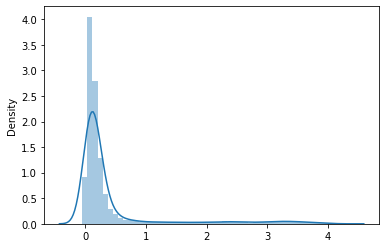

In [54]:
sns.distplot(v)
plt.show()

In [55]:
sub[:10]

,landmarks
id,
00084cdf8f600d00,159483 3.4858
000b15b043eb8cf0,51937 0.0107
0011a52f9b948fd2,85160 0.0597
00141b8a5a729084,35027 1.199
0018aa4b92532b77,8006 0.1421
001baaaab791d8db,117151 0.1121
002bc16418269c3d,151023 0.0922
0043158ee252596c,56136 0.1185
00441c9ba2d68ce4,13322 0.4268


In [56]:
nonlandmark_embeddings.shape

(115605, 1024)

In [57]:
test_embeddings.shape

(10345, 1024)

In [58]:
nonlandmark_embeddings.shape

(115605, 1024)

In [59]:
##----- 今回のnon_landmarkも同じ画像が使われている場合
# vals_2, inds_2 = get_topk_cossim(val_embeddings, nonlandmark_embeddings, k=11)
vals_2, inds_2 = get_topk_cossim(test_embeddings, nonlandmark_embeddings, k=11)

# starting from index 1 on val as index 0 is the same image
vals_2 = vals_2[:,1:].mean(axis=1).detach().cpu().numpy()


##----- 今回のnon_landmarkは違う画像が使われている場合
# # vals_2, inds_2 = get_topk_cossim(val_embeddings, nonlandmark_embeddings, k=11)
# vals_2, inds_2 = get_topk_cossim(test_embeddings[:,0:EMB_SIZE], nonlandmark_embeddings[:,0:EMB_SIZE], k=10)

# # starting from index 1 on val as index 0 is the same image
# vals_2 = vals_2[:,:].mean(axis=1).detach().cpu().numpy()

load tr_emb_global
GPU:0
process       5786 uses     5857.000 MB GPU memory
load test_emb_global
GPU:0
process       5786 uses     5857.000 MB GPU memory


  0%|          | 0/162 [00:00<?, ?it/s]

GPU:0
process       5786 uses     5857.000 MB GPU memory
del tr_emb_global and test_emb_global
GPU:0
process       5786 uses     5857.000 MB GPU memory


In [60]:
vals_2

array([0.2290419 , 0.4915039 , 0.42657095, ..., 0.44249573, 0.4631239 ,
       0.34460315], dtype=float32)

In [61]:
vals_2.shape

(10345,)

In [62]:
# penalize by C
import scipy as sp

l3 = pd.Series(l.copy()).reset_index(drop=True)
v3 = v.copy()

v3 -= 1*vals_2

#ここでsubmission.csvを作成する。

#　これはおまけ
# val_score = comp_metric(out_val["targets"][:], [l3[:], v3[:]], ignore_non_landmarks=False)
# print(val_score)
# val_score = comp_metric(out_val["targets"][:], [l3[:], v3[:]], ignore_non_landmarks=True)
# print(val_score)

In [63]:
v3

array([ 3.25672   , -0.48083025, -0.3668462 , ..., -0.33189538,
       -0.2381036 , -0.1879628 ], dtype=float32)

In [64]:
v3.shape

(10345,)

<AxesSubplot:ylabel='Density'>

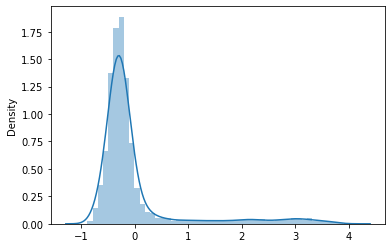

In [65]:
sns.distplot(v3)

In [66]:
sub=test.copy()

def concat(label, conf):
    return f'{str(int(label))} {str(np.round(conf,4))}'

sub['landmarks'] = [concat(label, conf) for label, conf in zip(l3, v3)]
sub = sub[['id','landmarks']].set_index('id')
sub.to_csv('submission.csv')

In [67]:
sub[:10]

,landmarks
id,
00084cdf8f600d00,159483 3.2567
000b15b043eb8cf0,51937 -0.4808
0011a52f9b948fd2,85160 -0.3668
00141b8a5a729084,35027 0.9159
0018aa4b92532b77,8006 -0.2847
001baaaab791d8db,117151 -0.2953
002bc16418269c3d,151023 -0.3323
0043158ee252596c,56136 -0.4022
00441c9ba2d68ce4,13322 0.0494
